## SWOO Recommendation System
Objective :
         
         The objective of this notebook is to built a recommender 
         system which will take input as the existing user_id 
         and recommend 10 videos.

**Tools & Technology :**
                 
                 Apache Spark Framework, PySpark, Jupter Notebook

**Algorithm :**
        
        Alternating Least Squares 

        ALS is one of the low rank matrix approximation algorithms for 
        collabrative filtering. 
        ALS decomposes user-item matrix into two low rank matrixes: user and 
        item matrix. 
### Project Content

1. Load Required Libraries
2. Spark Configuration
3. Spark SQL and OLAP
4. Spark ALS based approach for training model
5. ALS Model Optimization and Hyper Parameter Evaluation
6. Model Testing
7. Make Video Recommendation for given User

## Load the required libraries

In [5]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


# Spark Configuration

In [6]:
# spark config
spark = SparkSession \
    .builder \
    .appName("Swoo recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

# Load the data

In [7]:
ratings = spark.read.csv('040419_Rating.csv',header=True)


## Basic inspection

In [8]:
ratings.show(3)

+---+-------+--------+------------------------+---------------------------+-----+----------+-----+-----+-----+------+
|_c0|User_id|Video_id|videoplayer_shareclicked|videoplayer_downloadclicked|votes|     theme|Cond1|Cond2|Cond3|Rating|
+---+-------+--------+------------------------+---------------------------+-----+----------+-----+-----+-----+------+
|  0|6156680|  433441|                      No|                         No| 1004|Instrument|    0|    1| TRUE|     2|
|  1|6156680|  433400|                      No|                         No| null|     Dance|    0|    1|FALSE|     1|
|  2|6156680|  433400|                      No|                         No| null|     Dance|    0|    1|FALSE|     1|
+---+-------+--------+------------------------+---------------------------+-----+----------+-----+-----+-----+------+
only showing top 3 rows



In [9]:
ratings.schema

StructType(List(StructField(_c0,StringType,true),StructField(User_id,StringType,true),StructField(Video_id,StringType,true),StructField(videoplayer_shareclicked,StringType,true),StructField(videoplayer_downloadclicked,StringType,true),StructField(votes,StringType,true),StructField(theme,StringType,true),StructField(Cond1,StringType,true),StructField(Cond2,StringType,true),StructField(Cond3,StringType,true),StructField(Rating,StringType,true)))

### Change datatypes : String to integer

In [10]:
from pyspark.sql.types import IntegerType
ratings_1 = ratings.select("User_id","Video_id","Rating")
ratings_1 = ratings_1.withColumn("User_id", ratings_1["User_id"].cast(IntegerType()))
ratings_1 = ratings_1.withColumn("Video_id", ratings_1["Video_id"].cast(IntegerType()))
ratings_1 = ratings_1.withColumn("Rating", ratings_1["Rating"].cast(IntegerType()))
ratings_1.show(3)

+-------+--------+------+
|User_id|Video_id|Rating|
+-------+--------+------+
|6156680|  433441|     2|
|6156680|  433400|     1|
|6156680|  433400|     1|
+-------+--------+------+
only showing top 3 rows



# Spark SQL and OLAP

## Ratings - Descriptive summary

In [11]:
print('Distinct values of ratings:')
print(sorted(ratings_1.select('Rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[0, 1, 2, 3, 4, 5]


## Minimum number of ratings per user and min number of ratings per video

In [12]:
tmp1 = ratings_1.groupBy("User_id").count().toPandas()['count'].min()
tmp2 = ratings_1.groupBy("Video_id").count().toPandas()['count'].min()
print('For the users that rated videos and the videos that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per video is {}'.format(tmp2))

For the users that rated videos and the videos that were rated:
Minimum number of ratings per user is 1
Minimum number of ratings per video is 1


## How many video's are rated by only one user

In [13]:
tmp1 = sum(ratings_1.groupBy("Video_id").count().toPandas()['count'] == 1)
tmp2 = ratings_1.select('Video_id').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))


5 out of 949 movies are rated by only one user


## Total number of users in the dataset

In [14]:
tmp = ratings_1.select('User_id').distinct().count()
print('We have a total of {} distinct users in the dataset'.format(tmp))

We have a total of 25154 distinct users in the dataset


## Total number of videos in the dataset¶

In [15]:
tmp = ratings_1.select('Video_id').distinct().count()
print('We have a total of {} distinct videos in the dataset'.format(tmp))

We have a total of 949 distinct videos in the dataset


## List all distinct themes in the dataset

In [16]:
print('All distinct Themes: ')
ratings.select("theme").distinct().show()

All distinct Themes: 
+--------------------+
|               theme|
+--------------------+
|Instruments and S...|
|      Dance and Sing|
|          Instrument|
|    April Fool Theme|
|    Acting and Mimic|
|             Singing|
|                Holi|
|              Acting|
|              Horror|
|              Comedy|
|               Dance|
|      Specific Dance|
|           Anchoring|
+--------------------+



## Count of videos per theme

In [17]:
print('Counts of videos per theme')
ratings.select("theme") \
    .groupby('theme') \
    .count() \
    .sort(desc('count')) \
    .show()

Counts of videos per theme
+--------------------+-----+
|               theme|count|
+--------------------+-----+
|                Holi|89161|
|             Singing|55642|
|              Acting|40882|
|               Dance|37168|
|              Comedy|34472|
|          Instrument|26695|
|           Anchoring|23442|
|              Horror|19125|
|      Specific Dance|16742|
|    April Fool Theme|16223|
|    Acting and Mimic| 2196|
|      Dance and Sing|  380|
|Instruments and S...|  136|
+--------------------+-----+



# Spark ALS based approach for training model

    1.Reload data
    2.Split data into train, validation, test
    3.ALS Model selection and evaluation
    4.Model Testing
## Re-load data

We will use an RDD-based API from pyspark.mllb to reload the sdata using sc.textFile and convert it to the form of ( user_id, video_id, rating )

In [19]:
# load data
movie_rating = sc.textFile('140419_Movie_Rating.csv')
# preprocess data -- only need ["userId", "movieId", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), int(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(6156680, 433441, 2), (6156680, 433400, 1), (6156680, 433400, 1)]

### Split data¶

In [20]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[93] at RDD at PythonRDD.scala:53

### ALS Model selection and evaluation
With the ALS Model we can use grid search to find optimal hyperparameters


In [21]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [22]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.3538007252508162
8 latent factors and regularization = 0.01: validation RMSE is 0.3250707207240372
8 latent factors and regularization = 0.05: validation RMSE is 0.3272282883376022
8 latent factors and regularization = 0.1: validation RMSE is 0.3579655283320017
8 latent factors and regularization = 0.2: validation RMSE is 0.45247509104608735
10 latent factors and regularization = 0.001: validation RMSE is 0.34649845598291124
10 latent factors and regularization = 0.01: validation RMSE is 0.31936576592170013
10 latent factors and regularization = 0.05: validation RMSE is 0.32527368980715926
10 latent factors and regularization = 0.1: validation RMSE is 0.35812637193481894
10 latent factors and regularization = 0.2: validation RMSE is 0.4530615599610824
12 latent factors and regularization = 0.001: validation RMSE is 0.3565076758880799
12 latent factors and regularization = 0.01: validation RMSE is 0.31976573865943986
12 l

### ALS Model Learning Curve

In [23]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

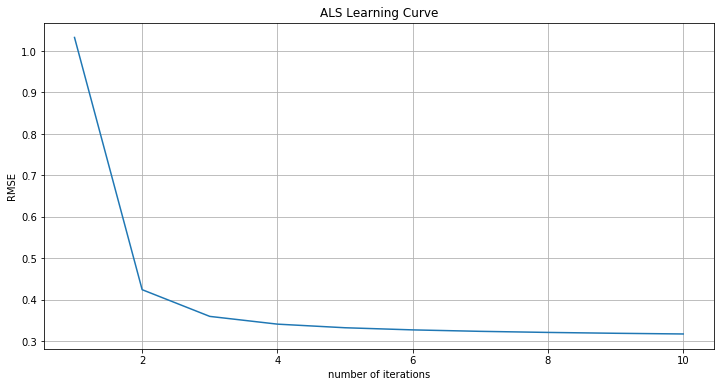

In [24]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 20)

### Model Testing

In [25]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.3093


## RecSys Model Building

### Function - 1

In [26]:
# Function : For the given user_id get all the video ids 
def get_videoId(user_id,df_videos):
    """
    return all movieId(s) of user's movies
    Parameters
    ----------
    user_id: User_id of the user
    Return
    ------
    videoId_list: list of videoId(s)
    """
    videoId_list = []
    videoIds = df_videos \
               .filter(ratings_1.User_id==user_id) \
               .select('Video_id') \
               .rdd \
               .map(lambda r: r[0]) \
               .collect()
    videoId_list.extend(videoIds)
    return list(set(videoId_list))

In [27]:
# Testing the function - get_videoId
user_id = 6156680 
df_videos = ratings_1
videoId_list = get_videoId(user_id,df_videos)
videoId_list

[433415,
 433419,
 433420,
 438926,
 438928,
 433434,
 433438,
 433439,
 433441,
 433445,
 439206,
 433456,
 433458,
 433459,
 433471,
 433363,
 438891,
 433391,
 433395,
 433400,
 438911]

### Function - 2

In [28]:
# Function : For the given user_id get all the video ids except the once the user watched

def get_inference_data(df_videos,videoId_list,user_id):
    """
    return a rdd with the userid and all videos (except ones in videoId_list)
    Parameters
    ----------
    df_videos: spark Dataframe, videos data
    videoId_list: list, list of videoId(s)
    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = user_id
    # return inference rdd
    return df_videos.rdd \
        .map(lambda r: r[1]) \
        .distinct() \
        .filter(lambda x: x not in videoId_list) \
        .map(lambda x: (new_id, x))

In [29]:
# Testing the function - get_inference_data 
user_id = 6156680 
df_videos = ratings_1
inference_rdd = get_inference_data(df_videos,videoId_list,user_id)
inference_rdd.take(3)

[(6156680, 438235), (6156680, 438340), (6156680, 437175)]

### Function - 3

In [30]:
best_model_params={'iterations': 10, 'rank': 18, 'lambda_': 0.01}
model = ALS.train(
        ratings=df_videos,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)

In [31]:
predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
predictions.take(3)

[(433296, 0.9337544478883697),
 (430296, 0.8673936521655591),
 (235812, 1.1765468086420698)]

In [32]:
n_recommendations=10
topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
topn_rows

[(431941, 2.283836676517974),
 (431769, 2.268973866739951),
 (431893, 2.2272607033597724),
 (431781, 2.16190729387624),
 (431980, 2.0680024510917843),
 (431972, 2.049878553490232),
 (431738, 2.040356578804485),
 (431830, 2.036955217159745),
 (431679, 2.027015033143499),
 (431685, 2.021499232707069)]

In [33]:
topn_ids = [r[0] for r in topn_rows]
topn_ids

[431941,
 431769,
 431893,
 431781,
 431980,
 431972,
 431738,
 431830,
 431679,
 431685]

### Model

In [36]:
# Function : For the given user_id get all the video ids 
def get_videoId(user_id,df_videos):
    """
    return all movieId(s) of user's movies
    Parameters
    ----------
    user_id: User_id of the user
    Return
    ------
    videoId_list: list of videoId(s)
    """
    videoId_list = []
    videoIds = df_videos \
               .filter(ratings_1.User_id==user_id) \
               .select('Video_id') \
               .rdd \
               .map(lambda r: r[0]) \
               .collect()
    videoId_list.extend(videoIds)
    return list(set(videoId_list))

# Function : For the given user_id get all the video ids except the once the user watched

def get_inference_data(df_videos,videoId_list,user_id):
    """
    return a rdd with the userid and all videos (except ones in videoId_list)
    Parameters
    ----------
    df_videos: spark Dataframe, videos data
    videoId_list: list, list of videoId(s)
    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = user_id
    # return inference rdd
    return df_videos.rdd \
        .map(lambda r: r[1]) \
        .distinct() \
        .filter(lambda x: x not in videoId_list) \
        .map(lambda x: (new_id, x))

def make_recommendation(best_model_params, df_videos, user_id,
                        n_recommendations, spark_context):
    """
    return top n video recommendation based on user's input list of favorite movies
    
    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}
    df_videos: spark Dataframe, movies data
    user_id: User_id of the user
    n_recommendations: int, top n recommendations
    spark_context: Spark Context object
    Return
    ------
    list of top n video recommendations
    """
    movieId_list = get_videoId(user_id,df_videos)
    # train best ALS
    model = ALS.train(
        ratings=df_videos,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(df_videos,videoId_list,user_id)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return video ids  
    return topn_ids

## Calling the RecSys for a sample userid

In [37]:
#Sample user_id : 6156680

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 18, 'lambda_': 0.01}, 
    df_videos = ratings_1, 
    user_id = 6156680,
    n_recommendations=10, 
    spark_context=sc)
    
print('Recommended Video ids for user {}:'.format(user_id))
print(recommends)

Recommended Video ids for user 6156680:
[431941, 431769, 431893, 431781, 431980, 431972, 431738, 431830, 431679, 431685]
